# Imports

In [1]:
import numpy as np
import pandas as pd
from  os import walk
from os.path import join
import multiprocessing as multiP
import psutil
import functools
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to C:\Users\Toyesh
[nltk_data]     Saini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Toyesh
[nltk_data]     Saini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# File Paths

In [2]:
SPAM_1_PATH = '/spam_assassin_corpus/spam_1'
SPAM_2_PATH = '/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = '/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = '/spam_assassin_corpus/easy_ham_2'

SPAM_CAT =1 
HAM_CAT =0

# Extracting mail bodies to DataFrame

In [3]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            stream =open(filepath,encoding='latin-1')


            is_body=False
            lines=[]

            for line in stream:

                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body=True

            stream.close

            email_body='\n'.join(lines)
            yield file_name, email_body
def df_from_directory(path, classification):
    rows = []
    row_names= []
    for file_name , email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body,'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index = row_names)

In [ ]:
workers_pool = multiP.Pool(psutil.cpu_count())
spam_mails_1, spam_mails_2 = workers_pool.map(functools.partial(df_from_directory, classification = SPAM_CAT), [SPAM_1_PATH, SPAM_2_PATH]) 
ham_mails_1, ham_mails_2 = workers_pool.map(functools.partial(df_from_directory, classification = HAM_CAT), [EASY_NONSPAM_1_PATH, EASY_NONSPAM_2_PATH]) 
workers_pool.close()
workers_pool.join()
workers_pool.terminate()

In [8]:
spam_mails = pd.concat([spam_mails_1, spam_mails_2])
ham_mails = pd.concat([ham_mails_1, ham_mails_2])
print(len(spam_mails))
print(len(ham_mails))

1898
3901


In [45]:
data = pd.concat([spam_mails, ham_mails])
print(data.shape)
data

(5799, 2)


,MESSAGE,CATEGORY
00247.4f7c67c9792706fa90fe218d4b092b7a,MR MARTIN FRANCIS\n\nABIDJAN COTE DIVOIRE\n\n...,1
00445.94d3ccfafc541255ff46625091d333e4,Hi -\n\n\n\n( http://club.4tfox.com )\n\n\n\nY...,1
00395.f9df5b3574ef5ba6143c08a1fa301886,<html>\n\n\n\n<head>\n\n<title>Home Page</titl...,1
00388.53eae0055e66fcb7194f9cca080fdefe,"PROFESSIONAL, EFFECTIVE DEBT COLLECTION SERVIC...",1
00045.7282c2c4e009744f2f3450d370009235,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00244.5cac9708afd7f9f00e9bf64eeb127f0a,=3C!DOCTYPE HTML PUBLIC =22-=2F=2FW3C=2F=2FDTD...,1
00213.8c42a1c257aa30ff3b3ba668cca59408,<p>We thank you for just a moment of your tim...,1
00449.7d33f465cb813806296901ee541841d6,"<HTML>\n\n<TABLE id=AutoNumber2 style=""BORDER-...",1
00039.889d785885f092c269741b11f2124dce,------=_NextPart_000_00X9_70A11C1D.E1232J43\n\...,1
00276.a6e447390e371ddba7cee092bb0ec98f,"<html>\n\n\n\n<head>\n\n<meta http-equiv=3D""Co...",1


# Processing

In [48]:
print(f"Number of rows with empty strings is : {sum(data['MESSAGE'].str.len()==0)}")

Number of rows with empty strings is : 3


In [49]:
data = data[data['MESSAGE'].str.len()!=0]
data

,MESSAGE,CATEGORY
00247.4f7c67c9792706fa90fe218d4b092b7a,MR MARTIN FRANCIS\n\nABIDJAN COTE DIVOIRE\n\n...,1
00445.94d3ccfafc541255ff46625091d333e4,Hi -\n\n\n\n( http://club.4tfox.com )\n\n\n\nY...,1
00395.f9df5b3574ef5ba6143c08a1fa301886,<html>\n\n\n\n<head>\n\n<title>Home Page</titl...,1
00388.53eae0055e66fcb7194f9cca080fdefe,"PROFESSIONAL, EFFECTIVE DEBT COLLECTION SERVIC...",1
00045.7282c2c4e009744f2f3450d370009235,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
...,...,...
00599.4b9e5d55f5bb001974345a0439e6f93d,-----BEGIN PGP SIGNED MESSAGE-----\n\nHash: SH...,0
00241.1cb3df109857b541b9829f93fb5189d1,Quoting Stephen_Reilly@dell.com (Stephen_Reill...,0
00918.0881c41b33de2efe11464c2fac2ed760,"Nope, a true geek would have a Blackberry so h...",0
00875.88008b119e71ad96444faf3f66f05bee,"On Wed, 2002-07-24 at 16:46, bitbitch@magnesiu...",0


In [50]:
data['FILE_NAME'] = data.index
data.sort_index(inplace=True)
data.reset_index(drop = True, inplace=True)
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,MESSAGE,CATEGORY,FILE_NAME
0,"Date: Tue, 20 Aug 2002 17:27:47 -05...",0,00001.1a31cc283af0060967a233d26548a6ce
1,Greetings!\n\n\n\nYou are receiving this lette...,1,00001.317e78fa8ee2f54cd4890fdc09ba8176
2,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
3,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0,00001.7c53336b37003a9286aba55d2945844c
4,--==_Exmh_-199405358P\n\nContent-Type: text/pl...,0,00002.5a587ae61666c5aa097c8e866aedcc59
...,...,...,...
5791,Man killed 'trying to surf' on Tube train \n\n...,0,02496.aae0c81581895acfe65323f344340856
5792,"Hi Gianni,\n\n\n\nA very good resource for thi...",0,02497.60497db0a06c2132ec2374b2898084d3
5793,Gianni Ponzi wrote:\n\n> I have a prob when tr...,0,02498.09835f512f156da210efb99fcc523e21
5794,Neale Pickett <neale@woozle.org> writes:\n\n\n...,0,02499.b4af165650f138b10f9941f6cc5bce3c


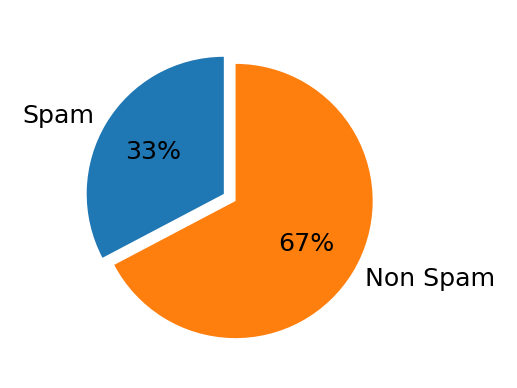

In [3]:
category_names = ['Spam', 'Non Spam']
sizes = [data['CATEGORY'].value_counts()[1], data['CATEGORY'].value_counts()[0]]
plt.figure(figsize=(2,2),dpi = 227) 
plt.pie(sizes, labels = category_names, textprops = {'fontsize':8},startangle=90,
       autopct='%1.0f%%', explode = [0,0.1]) 
plt.show()

In [15]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), stop_words = set(stopwords.words('english'))):
    
    #Removing html tags
    soup=BeautifulSoup(message,'html.parser')
    cleaned_text= soup.get_text()

    #converts to lowercase and splits up the words
    words = word_tokenize(cleaned_text.lower())
    filtered_words=[]
    
    for word in words:
        #Removes stopwords and punctuation
        if word not in stop_words and word.isalpha():
          filtered_words.append(stemmer.stem(word))
            
    return " ".join(filtered_words)      

In [16]:
data['clean_text'] = data.apply(lambda x: clean_msg_no_html(x['MESSAGE']), axis =1)

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
data.drop(columns= ['MESSAGE'], axis = 1, inplace = True)
data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,CATEGORY,FILE_NAME,clean_text
0,0,0,date tue aug chri garrigu hope peopl addit seq...
1,1,1,greet receiv letter express interest receiv in...
2,1,2,save life insur spend life quot save g famili ...
3,0,3,date wed aug chri garrigu ca reproduc error re...
4,0,4,date wed aug tue aug edt said ever tri get mh ...
...,...,...,...
5791,0,5791,man kill surf tube train ananova wednesday dec...
5792,0,5792,hi gianni good resourc http http walk guid umb...
5793,0,5793,gianni ponzi wrote prob tri instal linux tri r...
5794,0,5794,neal pickett write skip montanaro write ye als...


# Creating Vectors(Bag of Words Approach)

In [18]:
vectorizer = CountVectorizer(stop_words='english')
all_features = vectorizer.fit_transform(data.clean_text)

# Splitting to test and train sets

In [24]:
X_train ,X_test, y_train, y_test = train_test_split(all_features, data.CATEGORY, test_size =0.3 , random_state = 1)

In [25]:
X_train.shape

(4057, 27101)

In [26]:
X_test.shape

(1739, 27101)

# Pipeline

In [27]:
mnb_pipeline = Pipeline([
    ('mnb', MultinomialNB())
])
grid_params = {
  'mnb__alpha': np.linspace(0.1, 2.0, 20),
  'mnb__fit_prior': [True, False],  
}
clf = GridSearchCV(mnb_pipeline, grid_params)
clf.fit(X_train, y_train)
print("Best Score: ", clf.best_score_)
print("Best Params: ", clf.best_params_)

Best Score:  0.9775688956649031
Best Params:  {'mnb__alpha': 0.3, 'mnb__fit_prior': False}


In [28]:
classifier = MultinomialNB(alpha = 0.3, fit_prior = False)
classifier.fit(X_train , y_train)

MultinomialNB(alpha=0.3, class_prior=None, fit_prior=False)

# Evaluation metrics

In [34]:
print(f'Training accuracy of model is: {classifier.score(X_train, y_train):.3%}')
print(f'Testing accuracy of model is: {classifier.score(X_test, y_test):.3%}')

Training accuracy of model is: 98.669%
Testing accuracy of model is: 97.987%


In [36]:
print(f"Precision is: {precision_score(y_test, classifier.predict(X_test)):.3%}")
print(f"Recall score is: {recall_score(y_test, classifier.predict(X_test)):.3%}")
print(f"F1-score is: {f1_score(y_test, classifier.predict(X_test)):.3%}")

Precision is: 98.208%
Recall score is: 95.637%
F1-score is: 96.905%
